# Anime Recommendation System - Complete Walkthrough

Notebook này hướng dẫn toàn bộ quy trình xây dựng hệ thống gợi ý Anime, bao gồm:

1. **Data Loading & Exploration** - Tải và khám phá dữ liệu
2. **Data Cleaning & Preprocessing** - Làm sạch và tiền xử lý
3. **Data Visualization** - Trực quan hóa dữ liệu
4. **Train/Test Split** - Chia tập train/test
5. **Model Training** - Huấn luyện 4 mô hình
6. **Model Evaluation** - Đánh giá mô hình
7. **Save to MongoDB** - Lưu metrics lên database
8. **Recommendation Demo** - Demo gợi ý

---


## 1. Setup & Imports

In [112]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
import warnings
import asyncio

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# MongoDB
from motor.motor_asyncio import AsyncIOMotorClient
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Data Loading & Exploration

Dữ liệu được lấy từ [Kaggle - Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

Gồm 2 file:
- `anime.csv`: Thông tin về các anime
- `rating.csv`: Đánh giá của users cho các anime


In [113]:
# Load data
# Note: Paths are relative to notebook location (./notebooks/)
anime_df = pd.read_csv('../data/raw/anime.csv')
rating_df = pd.read_csv('../data/raw/rating.csv')

print(f"Anime Dataset: {anime_df.shape[0]:,} records, {anime_df.shape[1]} columns")
print(f"Rating Dataset: {rating_df.shape[0]:,} records, {rating_df.shape[1]} columns")


Anime Dataset: 12,294 records, 7 columns
Rating Dataset: 7,813,737 records, 3 columns


In [114]:
# Explore anime data
print("\nANIME DATASET")
print("=" * 50)
print(anime_df.info())
print("\n" + "=" * 50)
anime_df.head(10)



ANIME DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None



,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [115]:
# Explore rating data
print("\nRATING DATASET")
print("=" * 50)
print(rating_df.info())
print("\n" + "=" * 50)
rating_df.head(10)



RATING DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None



,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


In [116]:
# Basic statistics
print("ANIME STATISTICS")
print("=" * 50)
print(anime_df.describe())


ANIME STATISTICS
           anime_id        rating       members
count  12294.000000  12064.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.026746  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.880000  2.250000e+02
50%    10260.500000      6.570000  1.550000e+03
75%    24794.500000      7.180000  9.437000e+03
max    34527.000000     10.000000  1.013917e+06


In [117]:
# Check for missing values
print("\nMISSING VALUES")
print("=" * 50)
print("\nAnime Dataset:")
print(anime_df.isnull().sum())
print("\nRating Dataset:")
print(rating_df.isnull().sum())



MISSING VALUES

Anime Dataset:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Rating Dataset:
user_id     0
anime_id    0
rating      0
dtype: int64


## 3. Data Cleaning & Preprocessing

Các bước làm sạch dữ liệu:
1. Xử lý missing values
2. Chuyển đổi kiểu dữ liệu
3. Xử lý outliers
4. Tạo features mới


In [118]:
# Clean anime data
def clean_anime_data(df):
    df = df.copy()
    
    # Handle missing values
    df['name'] = df['name'].fillna('Unknown')
    df['genre'] = df['genre'].fillna('')
    df['type'] = df['type'].fillna('Unknown')
    
    # Convert episodes to numeric
    df['episodes'] = df['episodes'].replace('Unknown', np.nan)
    df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce').fillna(0).astype(int)
    
    # Handle rating
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(0.0)
    df['rating'] = df['rating'].clip(0, 10)
    
    # Handle members
    df['members'] = pd.to_numeric(df['members'], errors='coerce').fillna(0).astype(int)
    
    # Convert genre to list
    df['genre_list'] = df['genre'].apply(lambda x: [g.strip() for g in x.split(',')] if x else [])
    
    # Remove duplicates
    df = df.drop_duplicates(subset=['anime_id'])
    
    # Remove invalid IDs
    df = df[df['anime_id'] > 0]
    
    return df

anime_clean = clean_anime_data(anime_df)
print(f"Cleaned anime data: {len(anime_clean):,} records")
anime_clean.head()


Cleaned anime data: 12,294 records


,anime_id,name,genre,type,episodes,rating,members,genre_list
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,"[Action, Comedy, Historical, Parody, Samurai, ..."


In [119]:
# Clean rating data
def clean_rating_data(df, sample_size=None):
    df = df.copy()
    
    # Sample if too large
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
        print(f"Sampled to {sample_size:,} ratings")
    
    # Remove missing values
    df = df.dropna(subset=['user_id', 'anime_id'])
    
    # Convert types
    df['user_id'] = df['user_id'].astype(int)
    df['anime_id'] = df['anime_id'].astype(int)
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(-1).astype(int)
    
    # Remove duplicates (keep last)
    df = df.drop_duplicates(subset=['user_id', 'anime_id'], keep='last')
    
    # Filter valid ratings (-1 to 10)
    df = df[(df['rating'] >= -1) & (df['rating'] <= 10)]
    
    return df

# Sample for faster processing (use None for full data)
SAMPLE_SIZE = 500000  # Adjust as needed

rating_clean = clean_rating_data(rating_df, sample_size=SAMPLE_SIZE)
print(f"Cleaned rating data: {len(rating_clean):,} records")
rating_clean.head()


Sampled to 500,000 ratings
Cleaned rating data: 500,000 records


,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


In [120]:
# Filter only positive ratings for model training
rating_positive = rating_clean[rating_clean['rating'] > 0].copy()
print(f"Positive ratings (1-10): {len(rating_positive):,} records")

# Basic stats
print(f"\nRating Statistics:")
print(f"  - Unique users: {rating_positive['user_id'].nunique():,}")
print(f"  - Unique anime: {rating_positive['anime_id'].nunique():,}")
print(f"  - Average rating: {rating_positive['rating'].mean():.2f}")
print(f"  - Rating distribution: min={rating_positive['rating'].min()}, max={rating_positive['rating'].max()}")


Positive ratings (1-10): 405,543 records

Rating Statistics:
  - Unique users: 53,323
  - Unique anime: 7,327
  - Average rating: 7.81
  - Rating distribution: min=1, max=10


## 4. Data Visualization

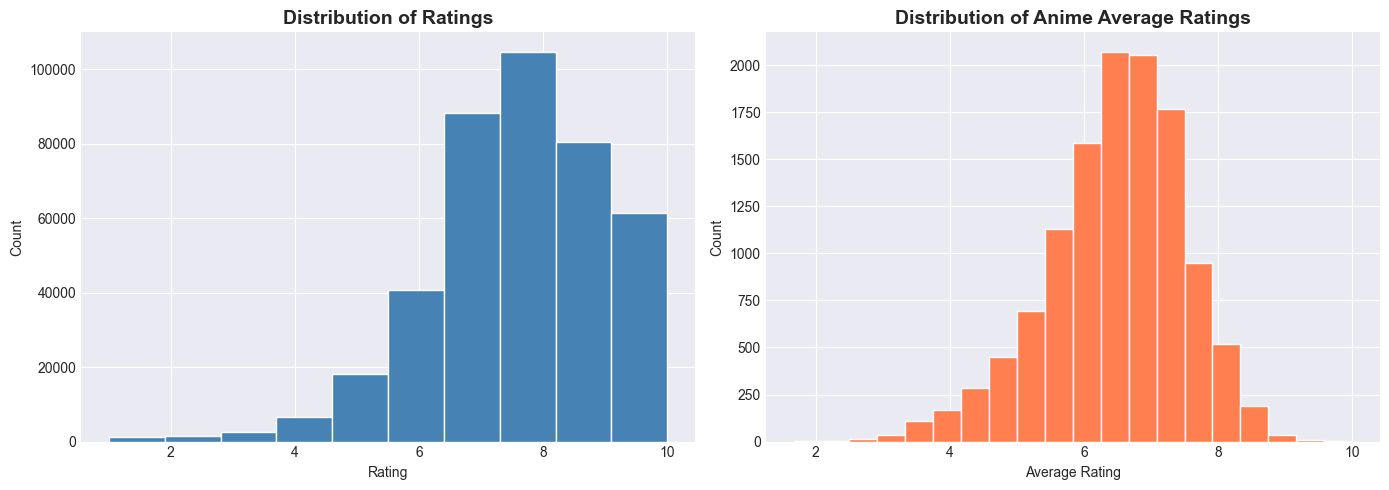

In [121]:
# Rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating distribution
rating_positive['rating'].hist(bins=10, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Anime rating distribution
anime_clean[anime_clean['rating'] > 0]['rating'].hist(bins=20, ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('Distribution of Anime Average Ratings', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


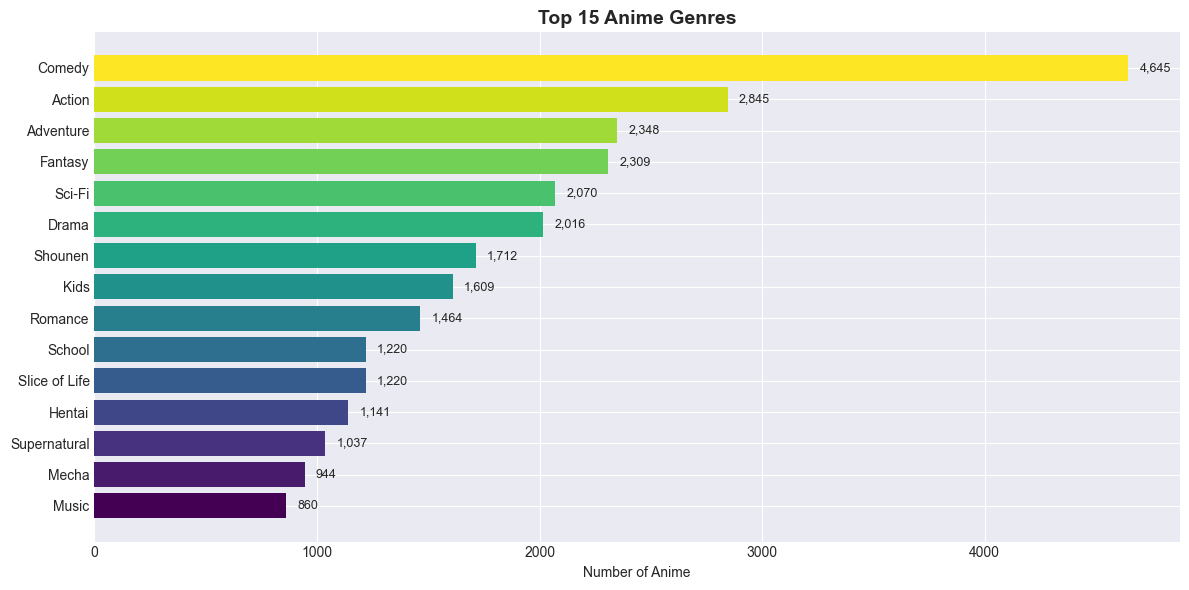

In [122]:
# Genre distribution
all_genres = []
for genres in anime_clean['genre_list']:
    all_genres.extend(genres)

genre_counts = pd.Series(all_genres).value_counts().head(15)

plt.figure(figsize=(12, 6))
bars = plt.barh(genre_counts.index[::-1], genre_counts.values[::-1], color=plt.cm.viridis(np.linspace(0, 1, 15)))
plt.title('Top 15 Anime Genres', fontsize=14, fontweight='bold')
plt.xlabel('Number of Anime')
for i, (v, name) in enumerate(zip(genre_counts.values[::-1], genre_counts.index[::-1])):
    plt.text(v + 50, i, f'{v:,}', va='center', fontsize=9)
plt.tight_layout()
plt.show()


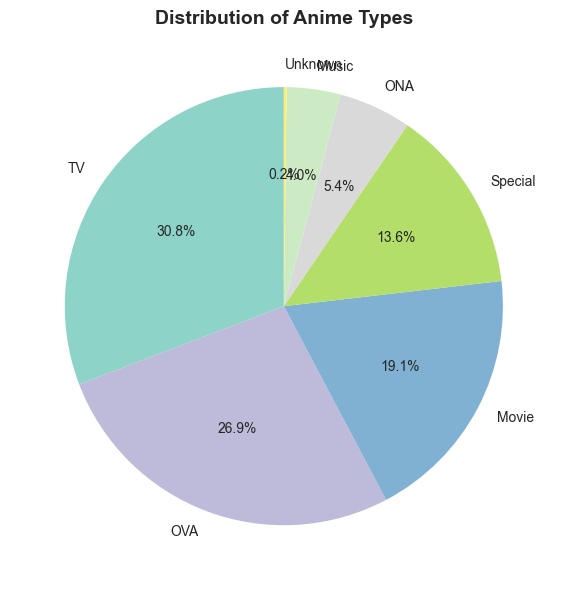

In [123]:
# Anime type distribution
type_counts = anime_clean['type'].value_counts()

plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Anime Types', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [124]:
# Top 10 anime by rating
top_anime = anime_clean.nlargest(10, 'rating')[['name', 'rating', 'members', 'type']]
print("TOP 10 ANIME BY RATING")
print("=" * 60)
top_anime


TOP 10 ANIME BY RATING


,name,rating,members,type
10464,Taka no Tsume 8: Yoshida-kun no X-Files,10.00,13,Movie
10400,Spoon-hime no Swing Kitchen,9.60,47,TV
9595,Mogura no Motoro,9.50,62,Movie
0,Kimi no Na wa.,9.37,200630,Movie
9078,Kahei no Umi,9.33,44,Movie
1,Fullmetal Alchemist: Brotherhood,9.26,793665,TV
2,Gintama°,9.25,114262,TV
10786,Yakusoku: Africa Mizu to Midori,9.25,53,OVA
3,Steins;Gate,9.17,673572,TV
4,Gintama&#039;,9.16,151266,TV


## 5. Train/Test Split

Chia dữ liệu thành tập train (80%) và test (20%).  
Đảm bảo mỗi user trong test set có đủ ratings trong train set (tránh cold-start).


In [125]:
def train_test_split(ratings_df, test_ratio=0.2, min_ratings=5):
    """Split ratings into train and test sets."""
    user_ratings = defaultdict(list)
    
    for _, row in ratings_df.iterrows():
        user_ratings[row['user_id']].append({
            'user_id': row['user_id'],
            'anime_id': row['anime_id'],
            'rating': row['rating']
        })
    
    train = []
    test = []
    
    for user_id, user_r in user_ratings.items():
        if len(user_r) <= min_ratings:
            train.extend(user_r)
        else:
            random.shuffle(user_r)
            n_test = max(1, int(len(user_r) * test_ratio))
            n_train = len(user_r) - n_test
            
            if n_train < min_ratings:
                n_train = min_ratings
                n_test = len(user_r) - n_train
            
            train.extend(user_r[:n_train])
            test.extend(user_r[n_train:])
    
    return train, test

# Split data
random.seed(42)
train_ratings, test_ratings = train_test_split(rating_positive, test_ratio=0.2)

print(f"Train set: {len(train_ratings):,} ratings")
print(f"Test set: {len(test_ratings):,} ratings")
print(f"Split ratio: {len(train_ratings)/(len(train_ratings)+len(test_ratings))*100:.1f}% / {len(test_ratings)/(len(train_ratings)+len(test_ratings))*100:.1f}%")


Train set: 348,511 ratings
Test set: 57,032 ratings
Split ratio: 85.9% / 14.1%


## 6. Model Training

Xây dựng 4 mô hình recommendation:

1. **Content-Based Filtering** - Gợi ý dựa trên đặc điểm anime (genres)
2. **Item-Based Collaborative Filtering** - Gợi ý dựa trên sự tương đồng giữa các anime
3. **User-Based Collaborative Filtering** - Gợi ý dựa trên sự tương đồng giữa các users
4. **Hybrid Model** - Kết hợp nhiều phương pháp


### 6.1 Content-Based Filtering

In [126]:
class ContentBasedRecommender:
    """Content-based filtering using TF-IDF on genres."""
    
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.tfidf_matrix = None
        self.anime_ids = []
        self.anime_id_to_idx = {}
        self.anime_data = {}
    
    def fit(self, anime_df):
        """Train the model."""
        self.anime_ids = anime_df['anime_id'].tolist()
        self.anime_id_to_idx = {aid: idx for idx, aid in enumerate(self.anime_ids)}
        self.anime_data = {row['anime_id']: row for _, row in anime_df.iterrows()}
        
        # Create genre strings
        genre_strings = anime_df['genre'].fillna('').tolist()
        
        # Fit TF-IDF
        self.tfidf_matrix = self.tfidf.fit_transform(genre_strings)
        
        print(f"Content-Based model fitted with {len(self.anime_ids)} anime")
        return self
    
    def get_similar_anime(self, anime_id, n=10):
        """Get similar anime based on genre."""
        if anime_id not in self.anime_id_to_idx:
            return []
        
        idx = self.anime_id_to_idx[anime_id]
        anime_vec = self.tfidf_matrix[idx]
        similarities = cosine_similarity(anime_vec, self.tfidf_matrix).flatten()
        
        similar_idx = similarities.argsort()[::-1][1:n+1]
        return [self.anime_ids[i] for i in similar_idx]
    
    def predict(self, user_id, n=10, liked_anime_ids=None):
        """Get recommendations for a user."""
        if not liked_anime_ids:
            return []
        
        recommendations = {}
        for anime_id in liked_anime_ids:
            similar = self.get_similar_anime(anime_id, n=20)
            for sim_id in similar:
                if sim_id not in liked_anime_ids:
                    recommendations[sim_id] = recommendations.get(sim_id, 0) + 1
        
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return [aid for aid, _ in sorted_recs[:n]]
    
    def predict_rating(self, user_id, anime_id):
        """Predict rating (returns anime's average rating)."""
        if anime_id in self.anime_data:
            return self.anime_data[anime_id].get('rating', 5.0)
        return 5.0

# Train Content-Based model
content_model = ContentBasedRecommender()
content_model.fit(anime_clean)


Content-Based model fitted with 12294 anime


### 6.2 Item-Based Collaborative Filtering

In [127]:
class ItemBasedRecommender:
    """Item-based collaborative filtering with sparse matrix optimization."""
    
    def __init__(self, k_neighbors=20):
        self.k = k_neighbors
        self.rating_matrix = None
        self.item_similarity = None
        self.user_id_to_idx = {}
        self.anime_id_to_idx = {}
        self.idx_to_anime_id = {}
        self.item_means = None
    
    def fit(self, ratings):
        """Train the model."""
        users = sorted(set(r['user_id'] for r in ratings))
        items = sorted(set(r['anime_id'] for r in ratings))
        
        self.user_id_to_idx = {uid: idx for idx, uid in enumerate(users)}
        self.anime_id_to_idx = {aid: idx for idx, aid in enumerate(items)}
        self.idx_to_anime_id = {idx: aid for aid, idx in self.anime_id_to_idx.items()}
        
        n_users, n_items = len(users), len(items)
        
        # Build sparse matrix
        row, col, data = [], [], []
        for r in ratings:
            if r['rating'] > 0:
                row.append(self.user_id_to_idx[r['user_id']])
                col.append(self.anime_id_to_idx[r['anime_id']])
                data.append(r['rating'])
        
        self.rating_matrix = csr_matrix((data, (row, col)), shape=(n_users, n_items))
        
        # Calculate item means
        item_sums = np.array(self.rating_matrix.sum(axis=0)).flatten()
        item_counts = np.array((self.rating_matrix > 0).sum(axis=0)).flatten()
        self.item_means = np.divide(item_sums, item_counts, 
                                    out=np.zeros_like(item_sums, dtype=float), 
                                    where=item_counts > 0)
        
        # Calculate item similarity (sparse output)
        if n_items <= 15000:
            print(f"  Computing item similarity matrix ({n_items}x{n_items})...")
            item_user_matrix = self.rating_matrix.T.tocsr()
            self.item_similarity = cosine_similarity(item_user_matrix, dense_output=False)
        else:
            print(f"  Warning: Too many items ({n_items}), skipping similarity computation")
        
        print(f"Item-Based model fitted: {n_users} users, {n_items} items")
        return self
    
    def predict(self, user_id, n=10):
        """Get recommendations for a user - OPTIMIZED with sparse operations."""
        if user_id not in self.user_id_to_idx:
            return []
        
        user_idx = self.user_id_to_idx[user_id]
        
        # Use sparse row directly - avoid toarray()
        user_ratings_sparse = self.rating_matrix.getrow(user_idx)
        rated_indices = user_ratings_sparse.indices
        rated_values = user_ratings_sparse.data
        
        if len(rated_indices) == 0:
            return []
        
        if self.item_similarity is None:
            return []
        
        # OPTIMIZED: Iterate through RATED items instead of ALL items
        # Complexity: O(rated × k_neighbors) instead of O(n_items)
        n_items = len(self.anime_id_to_idx)
        predictions = np.zeros(n_items)
        sim_sums = np.zeros(n_items)
        
        rated_set = set(rated_indices)
        
        # For each rated item, find similar items and accumulate
        for i, rated_idx in enumerate(rated_indices):
            user_rating = rated_values[i]
            
            # Get sparse row from similarity matrix
            sim_row = self.item_similarity.getrow(rated_idx)
            similar_indices = sim_row.indices
            similar_values = sim_row.data
            
            # Only take top-k neighbors if needed
            if len(similar_indices) > self.k:
                top_k_positions = similar_values.argsort()[::-1][:self.k]
                similar_indices = similar_indices[top_k_positions]
                similar_values = similar_values[top_k_positions]
            
            # Accumulate weighted sum for each similar item
            for j, sim_idx in enumerate(similar_indices):
                if sim_idx in rated_set:
                    continue  # Skip already rated items
                sim = similar_values[j]
                if sim > 0:
                    predictions[sim_idx] += sim * user_rating
                    sim_sums[sim_idx] += sim
        
        # Normalize predictions
        valid_mask = sim_sums > 0
        predictions[valid_mask] /= sim_sums[valid_mask]
        
        # Add popularity bias to boost popular items
        item_popularity = np.array(self.rating_matrix.sum(axis=0)).flatten()
        if item_popularity.max() > 0:
            item_popularity = item_popularity / item_popularity.max()  # Normalize 0-1
            # Blend: 70% similarity-based + 30% popularity
            max_pred = predictions.max() if predictions.max() > 0 else 1.0
            predictions[valid_mask] = 0.7 * predictions[valid_mask] + 0.3 * item_popularity[valid_mask] * max_pred
        
        # Get top N (exclude already rated items)
        predictions[rated_indices] = 0
        top_idx = predictions.argsort()[::-1][:n]
        return [self.idx_to_anime_id[idx] for idx in top_idx if predictions[idx] > 0]
    
    def predict_rating(self, user_id, anime_id):
        """Predict rating for user-anime pair."""
        if user_id not in self.user_id_to_idx or anime_id not in self.anime_id_to_idx:
            return 5.0
        
        user_idx = self.user_id_to_idx[user_id]
        item_idx = self.anime_id_to_idx[anime_id]
        
        # Use sparse operations
        user_ratings_sparse = self.rating_matrix.getrow(user_idx)
        rated_indices = user_ratings_sparse.indices
        rated_values = user_ratings_sparse.data
        
        if len(rated_indices) == 0 or self.item_similarity is None:
            return self.item_means[item_idx] if self.item_means[item_idx] > 0 else 5.0
        
        # Get similarities for target item
        sims = self.item_similarity.getrow(item_idx).toarray().ravel()
        
        # Find top-k similar items that user has rated
        rated_sims = []
        for i, rated_idx in enumerate(rated_indices):
            sim = sims[rated_idx]
            if sim > 0:
                rated_sims.append((rated_values[i], sim))
        
        rated_sims.sort(key=lambda x: x[1], reverse=True)
        top_k = rated_sims[:self.k]
        
        if not top_k:
            return self.item_means[item_idx] if self.item_means[item_idx] > 0 else 5.0
        
        num = sum(sim * rating for rating, sim in top_k)
        den = sum(sim for _, sim in top_k)
        return num / den if den > 0 else self.item_means[item_idx]

# Train Item-Based model with more neighbors for better coverage
item_model = ItemBasedRecommender(k_neighbors=50)
item_model.fit(train_ratings)


  Computing item similarity matrix (7103x7103)...
Item-Based model fitted: 53323 users, 7103 items


### 6.3 User-Based Collaborative Filtering

In [128]:
class UserBasedRecommender:
    """User-based collaborative filtering with sparse matrix optimization."""
    
    def __init__(self, k_neighbors=20):
        self.k = k_neighbors
        self.rating_matrix = None
        self.user_similarity = None
        self.user_id_to_idx = {}
        self.anime_id_to_idx = {}
        self.idx_to_anime_id = {}
        self.user_means = None
    
    def fit(self, ratings):
        """Train the model."""
        users = sorted(set(r['user_id'] for r in ratings))
        items = sorted(set(r['anime_id'] for r in ratings))
        
        self.user_id_to_idx = {uid: idx for idx, uid in enumerate(users)}
        self.anime_id_to_idx = {aid: idx for idx, aid in enumerate(items)}
        self.idx_to_anime_id = {idx: aid for aid, idx in self.anime_id_to_idx.items()}
        
        n_users, n_items = len(users), len(items)
        
        # Build sparse matrix - only positive ratings
        row, col, data = [], [], []
        for r in ratings:
            if r['rating'] > 0:
                row.append(self.user_id_to_idx[r['user_id']])
                col.append(self.anime_id_to_idx[r['anime_id']])
                data.append(r['rating'])
        
        self.rating_matrix = csr_matrix((data, (row, col)), shape=(n_users, n_items))
        
        # Calculate user means
        user_sums = np.array(self.rating_matrix.sum(axis=1)).flatten()
        user_counts = np.array((self.rating_matrix > 0).sum(axis=1)).flatten()
        self.user_means = np.divide(user_sums, user_counts,
                                    out=np.zeros_like(user_sums, dtype=float),
                                    where=user_counts > 0)
        
        # Calculate user similarity (sparse output)
        if n_users <= 20000:
            print(f"  Computing user similarity matrix ({n_users}x{n_users})...")
            self.user_similarity = cosine_similarity(self.rating_matrix, dense_output=False)
        else:
            print(f"  Warning: Too many users ({n_users}), skipping similarity computation")
        
        print(f"User-Based model fitted: {n_users} users, {n_items} items")
        return self
    
    def _get_user_similarities(self, user_idx):
        """Get similarities for a user - supports on-demand computation."""
        if self.user_similarity is not None:
            return self.user_similarity.getrow(user_idx).toarray().ravel()
        else:
            # On-demand computation for large datasets
            user_vector = self.rating_matrix.getrow(user_idx)
            return cosine_similarity(user_vector, self.rating_matrix).ravel()
    
    def predict(self, user_id, n=10):
        """Get recommendations for a user - with on-demand similarity support."""
        if user_id not in self.user_id_to_idx:
            return []
        
        user_idx = self.user_id_to_idx[user_id]
        
        # Use sparse row directly
        user_ratings_sparse = self.rating_matrix.getrow(user_idx)
        rated_items = set(user_ratings_sparse.indices)
        
        if len(rated_items) == 0:
            return []
        
        # Get similar users (supports on-demand computation)
        sims = self._get_user_similarities(user_idx)
        similar_users = sims.argsort()[::-1][1:self.k+1]
        
        predictions = {}
        for sim_user_idx in similar_users:
            sim = sims[sim_user_idx]
            if sim <= 0:
                continue
            
            # Use sparse row - iterate only through non-zero elements
            sim_user_sparse = self.rating_matrix.getrow(sim_user_idx)
            
            for idx, item_idx in enumerate(sim_user_sparse.indices):
                if item_idx in rated_items:
                    continue
                    
                rating = sim_user_sparse.data[idx]
                if item_idx not in predictions:
                    predictions[item_idx] = {'weighted_sum': 0.0, 'sim_sum': 0.0}
                predictions[item_idx]['weighted_sum'] += sim * rating
                predictions[item_idx]['sim_sum'] += sim
        
        pred_ratings = []
        for item_idx, data in predictions.items():
            if data['sim_sum'] > 0:
                pred = data['weighted_sum'] / data['sim_sum']
                pred_ratings.append((item_idx, pred))
        
        pred_ratings.sort(key=lambda x: x[1], reverse=True)
        return [self.idx_to_anime_id[idx] for idx, _ in pred_ratings[:n]]
    
    def predict_rating(self, user_id, anime_id):
        """Predict rating for user-anime pair."""
        if user_id not in self.user_id_to_idx or anime_id not in self.anime_id_to_idx:
            return 5.0
        
        user_idx = self.user_id_to_idx[user_id]
        item_idx = self.anime_id_to_idx[anime_id]
        
        # Get similarities (supports on-demand)
        sims = self._get_user_similarities(user_idx)
        similar_users = sims.argsort()[::-1][1:self.k+1]
        
        weighted_sum, sim_sum = 0.0, 0.0
        for sim_user_idx in similar_users:
            sim = sims[sim_user_idx]
            if sim <= 0:
                continue
            rating = self.rating_matrix[sim_user_idx, item_idx]
            if rating > 0:
                weighted_sum += sim * rating
                sim_sum += sim
        
        if sim_sum > 0:
            return weighted_sum / sim_sum
        return self.user_means[user_idx] if self.user_means[user_idx] > 0 else 5.0

# Train User-Based model with more neighbors for better coverage
user_model = UserBasedRecommender(k_neighbors=50)
user_model.fit(train_ratings)


User-Based model fitted: 53323 users, 7103 items


### 6.4 Hybrid Model

In [129]:
class HybridRecommender:
    """Hybrid model combining content-based and collaborative filtering."""
    
    def __init__(self, content_weight=0.3, item_weight=0.35, user_weight=0.35):
        self.content_weight = content_weight
        self.item_weight = item_weight
        self.user_weight = user_weight
        
        # Normalize weights
        total = content_weight + item_weight + user_weight
        self.content_weight /= total
        self.item_weight /= total
        self.user_weight /= total
        
        self.content_model = None
        self.item_model = None
        self.user_model = None
        self.user_ratings = {}
    
    def fit(self, anime_df, ratings, content_model, item_model, user_model):
        """Use pre-trained models."""
        self.content_model = content_model
        self.item_model = item_model
        self.user_model = user_model
        
        # Store user ratings
        for r in ratings:
            uid = r['user_id']
            if uid not in self.user_ratings:
                self.user_ratings[uid] = {}
            self.user_ratings[uid][r['anime_id']] = r['rating']
        
        print(f"Hybrid model ready with weights: Content={self.content_weight:.2f}, "
              f"Item={self.item_weight:.2f}, User={self.user_weight:.2f}")
        return self
    
    def predict(self, user_id, n=10):
        """Get recommendations combining all models."""
        recommendations = {}
        
        # Content-based
        if user_id in self.user_ratings:
            liked = [aid for aid, rating in self.user_ratings[user_id].items() if rating >= 7]
            if liked and self.content_model:
                content_recs = self.content_model.predict(user_id, n=n*2, liked_anime_ids=liked)
                for i, aid in enumerate(content_recs):
                    score = self.content_weight * (1 - i/len(content_recs))
                    recommendations[aid] = recommendations.get(aid, 0) + score
        
        # Item-based
        if self.item_model:
            try:
                item_recs = self.item_model.predict(user_id, n=n*2)
                for i, aid in enumerate(item_recs):
                    score = self.item_weight * (1 - i/len(item_recs))
                    recommendations[aid] = recommendations.get(aid, 0) + score
            except:
                pass
        
        # User-based
        if self.user_model:
            try:
                user_recs = self.user_model.predict(user_id, n=n*2)
                for i, aid in enumerate(user_recs):
                    score = self.user_weight * (1 - i/len(user_recs))
                    recommendations[aid] = recommendations.get(aid, 0) + score
            except:
                pass
        
        # Filter rated items
        rated = set(self.user_ratings.get(user_id, {}).keys())
        recommendations = {k: v for k, v in recommendations.items() if k not in rated}
        
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return [aid for aid, _ in sorted_recs[:n]]
    
    def predict_rating(self, user_id, anime_id):
        """Predict rating using weighted average."""
        preds, weights = [], []
        
        if self.content_model:
            preds.append(self.content_model.predict_rating(user_id, anime_id))
            weights.append(self.content_weight)
        
        if self.item_model:
            try:
                preds.append(self.item_model.predict_rating(user_id, anime_id))
                weights.append(self.item_weight)
            except:
                pass
        
        if self.user_model:
            try:
                preds.append(self.user_model.predict_rating(user_id, anime_id))
                weights.append(self.user_weight)
            except:
                pass
        
        if not preds:
            return 5.0
        
        return sum(p * w for p, w in zip(preds, weights)) / sum(weights)

# Train Hybrid model
hybrid_model = HybridRecommender()
hybrid_model.fit(anime_clean, train_ratings, content_model, item_model, user_model)


Hybrid model ready with weights: Content=0.30, Item=0.35, User=0.35


### 6.5 Save Models to Local

In [130]:
import pickle
import os

# Create models directory (relative to notebook location)
MODELS_PATH = '../trained_models'
os.makedirs(MODELS_PATH, exist_ok=True)

def save_model(model, filename):
    """Save model to pickle file."""
    filepath = os.path.join(MODELS_PATH, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filepath}")

def load_model(filename):
    """Load model from pickle file."""
    filepath = os.path.join(MODELS_PATH, filename)
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Save all models
print("Saving models to local...")
save_model(content_model, 'content_based.pkl')
save_model(item_model, 'item_based.pkl')
save_model(user_model, 'user_based.pkl')
save_model(hybrid_model, 'hybrid.pkl')

print(f"\nAll models saved to: {MODELS_PATH}/")
print("Files:")
for f in os.listdir(MODELS_PATH):
    if f.endswith('.pkl'):
        size = os.path.getsize(os.path.join(MODELS_PATH, f)) / 1024 / 1024
        print(f"  - {f} ({size:.2f} MB)")


Saving models to local...
Saved: ../trained_models\content_based.pkl
Saved: ../trained_models\item_based.pkl
Saved: ../trained_models\user_based.pkl
Saved: ../trained_models\hybrid.pkl

All models saved to: ../trained_models/
Files:
  - content_based.pkl (4.39 MB)
  - hybrid.pkl (61.21 MB)
  - item_based.pkl (40.40 MB)
  - user_based.pkl (4.36 MB)


## 7. Model Evaluation

Đánh giá các mô hình với các metrics:
- **RMSE** (Root Mean Square Error) - Đánh giá dự đoán rating
- **MAE** (Mean Absolute Error) - Đánh giá dự đoán rating
- **Precision@K** - Tỷ lệ items relevant trong top-K recommendations
- **Recall@K** - Tỷ lệ items relevant được recommend
- **NDCG@K** - Normalized Discounted Cumulative Gain


In [131]:
# Evaluation metrics
def rmse(predictions):
    if not predictions:
        return 0.0
    squared_errors = [(actual - pred) ** 2 for actual, pred in predictions]
    return np.sqrt(np.mean(squared_errors))

def mae(predictions):
    if not predictions:
        return 0.0
    return np.mean([abs(actual - pred) for actual, pred in predictions])

def precision_at_k(recommended, relevant, k):
    if k <= 0 or not recommended:
        return 0.0
    rec_k = set(recommended[:k])
    rel_set = set(relevant)
    return len(rec_k & rel_set) / k

def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    rec_k = set(recommended[:k])
    rel_set = set(relevant)
    return len(rec_k & rel_set) / len(rel_set)

def ndcg_at_k(recommended, relevant, k):
    if not recommended or not relevant:
        return 0.0
    rel_set = set(relevant)
    
    dcg = sum(1.0 / np.log2(i + 2) for i, item in enumerate(recommended[:k]) if item in rel_set)
    ideal_length = min(k, len(relevant))
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_length))
    
    return dcg / idcg if idcg > 0 else 0.0

print("Evaluation metrics defined")


Evaluation metrics defined


In [132]:
# DEBUG: Check model status and test predictions
print("=" * 60)
print("DEBUG: Model Status Check")
print("=" * 60)

# Check Item-Based model
print("\n--- Item-Based Model ---")
print(f"  Rating matrix: {item_model.rating_matrix.shape}")
print(f"  Rating matrix nnz: {item_model.rating_matrix.nnz}")
if item_model.item_similarity is not None:
    print(f"  Item similarity: {item_model.item_similarity.shape}")
    print(f"  Item similarity nnz: {item_model.item_similarity.nnz}")
else:
    print("  Item similarity: None (NOT COMPUTED!)")

# Check User-Based model
print("\n--- User-Based Model ---")
print(f"  Rating matrix: {user_model.rating_matrix.shape}")
print(f"  Rating matrix nnz: {user_model.rating_matrix.nnz}")
if user_model.user_similarity is not None:
    print(f"  User similarity: {user_model.user_similarity.shape}")
    print(f"  User similarity nnz: {user_model.user_similarity.nnz}")
else:
    print("  User similarity: None (NOT COMPUTED!)")

# Test predictions for a sample user
test_user_ids = list(set(r['user_id'] for r in train_ratings))[:5]
print(f"\n--- Test Predictions for sample users ---")

for test_uid in test_user_ids:
    print(f"\nUser {test_uid}:")
    
    # Item-Based
    item_recs = item_model.predict(test_uid, n=5)
    print(f"  Item-Based recs: {item_recs}")
    
    # User-Based
    user_recs = user_model.predict(test_uid, n=5)
    print(f"  User-Based recs: {user_recs}")
    
    if not item_recs:
        # Debug why no recs
        if test_uid in item_model.user_id_to_idx:
            user_idx = item_model.user_id_to_idx[test_uid]
            user_sparse = item_model.rating_matrix.getrow(user_idx)
            print(f"    -> User has {len(user_sparse.indices)} rated items")
        else:
            print(f"    -> User NOT in model!")
    
    if not user_recs:
        if test_uid in user_model.user_id_to_idx:
            user_idx = user_model.user_id_to_idx[test_uid]
            user_sparse = user_model.rating_matrix.getrow(user_idx)
            print(f"    -> User has {len(user_sparse.indices)} rated items")
            if user_model.user_similarity is not None:
                sim_row = user_model.user_similarity.getrow(user_idx)
                print(f"    -> User has {sim_row.nnz} similar users")
        else:
            print(f"    -> User NOT in model!")
    break  # Only debug first user

print("\n" + "=" * 60)


DEBUG: Model Status Check

--- Item-Based Model ---
  Rating matrix: (53323, 7103)
  Rating matrix nnz: 348511
  Item similarity: (7103, 7103)
  Item similarity nnz: 3177547

--- User-Based Model ---
  Rating matrix: (53323, 7103)
  Rating matrix nnz: 348511
  User similarity: None (NOT COMPUTED!)

--- Test Predictions for sample users ---

User 3:
  Item-Based recs: [788, 8302, 854, 30344, 1198]
  User-Based recs: [1604, 15451, 120, 6702, 4181]



In [133]:
def evaluate_model(model, test_ratings, train_ratings, k=10, threshold=6.0, model_name="Model"):
    """Evaluate a recommendation model."""
    print(f"\nEvaluating {model_name}...")
    
    # Build user -> relevant items from test (items with rating >= threshold)
    user_relevant = defaultdict(list)
    for r in test_ratings:
        if r['rating'] >= threshold:
            user_relevant[r['user_id']].append(r['anime_id'])
    
    # Build user -> ALL items in test (for checking overlap)
    user_test_items = defaultdict(set)
    for r in test_ratings:
        user_test_items[r['user_id']].add(r['anime_id'])
    
    # Build user -> liked items from train (for content-based)
    user_liked = defaultdict(list)
    for r in train_ratings:
        if r['rating'] >= threshold:
            user_liked[r['user_id']].append(r['anime_id'])
    
    # Get users that exist in model (for CF models)
    model_users = set()
    if hasattr(model, 'user_id_to_idx'):
        model_users = set(model.user_id_to_idx.keys())
    elif hasattr(model, 'user_ratings'):
        model_users = set(model.user_ratings.keys())
    
    rating_preds = []
    all_precisions, all_recalls, all_ndcgs = [], [], []
    users_evaluated = 0
    users_with_recs = 0
    total_hits = 0
    
    # Filter users that have relevant items AND exist in model
    users = list(user_relevant.keys())
    if model_users:
        users = [u for u in users if u in model_users]
    
    # Sample users for faster evaluation
    if len(users) > 500:
        users = random.sample(users, 500)
    
    print(f"  Users to evaluate: {len(users)}")
    
    for user_id in users:
        relevant = user_relevant[user_id]
        if not relevant:
            continue
        
        users_evaluated += 1
        
        try:
            # Get recommendations
            if model_name == "Content-Based":
                liked = user_liked.get(user_id, [])
                if not liked:
                    continue
                recs = model.predict(user_id, n=k*2, liked_anime_ids=liked)[:k]
            else:
                recs = model.predict(user_id, n=k)
            
            if recs and len(recs) > 0:
                users_with_recs += 1
                
                # Count hits
                hits = len(set(recs) & set(relevant))
                total_hits += hits
                
                all_precisions.append(precision_at_k(recs, relevant, k))
                all_recalls.append(recall_at_k(recs, relevant, k))
                all_ndcgs.append(ndcg_at_k(recs, relevant, k))
        except Exception as e:
            continue
    
    print(f"  Users evaluated: {users_evaluated}, Users with recs: {users_with_recs}, Total hits: {total_hits}")
    
    # Rating predictions - sample for speed
    if model_users:
        valid_test = [r for r in test_ratings if r['user_id'] in model_users]
    else:
        valid_test = test_ratings
    
    test_sample = random.sample(valid_test, min(1000, len(valid_test)))
    
    for r in test_sample:
        try:
            pred = model.predict_rating(r['user_id'], r['anime_id'])
            if pred is not None and pred > 0:
                rating_preds.append((r['rating'], pred))
        except:
            continue
    
    print(f"  Rating predictions: {len(rating_preds)}")
    
    metrics = {
        'rmse': round(rmse(rating_preds), 4) if rating_preds else 0.0,
        'mae': round(mae(rating_preds), 4) if rating_preds else 0.0,
        'precision_k': round(np.mean(all_precisions), 4) if all_precisions else 0.0,
        'recall_k': round(np.mean(all_recalls), 4) if all_recalls else 0.0,
        'ndcg_k': round(np.mean(all_ndcgs), 4) if all_ndcgs else 0.0,
    }
    
    print(f"  RMSE: {metrics['rmse']}, MAE: {metrics['mae']}")
    print(f"  Precision@{k}: {metrics['precision_k']}, Recall@{k}: {metrics['recall_k']}, NDCG@{k}: {metrics['ndcg_k']}")
    
    return metrics

# Evaluate all models with threshold=7 (higher quality relevant items) and k=20
print("=" * 60)
print("MODEL EVALUATION (threshold=7.0, k=20)")
print("=" * 60)

content_metrics = evaluate_model(content_model, test_ratings, train_ratings, k=20, threshold=7.0, model_name="Content-Based")
item_metrics = evaluate_model(item_model, test_ratings, train_ratings, k=20, threshold=7.0, model_name="Item-Based CF")
user_metrics = evaluate_model(user_model, test_ratings, train_ratings, k=20, threshold=7.0, model_name="User-Based CF")
hybrid_metrics = evaluate_model(hybrid_model, test_ratings, train_ratings, k=20, threshold=7.0, model_name="Hybrid")


MODEL EVALUATION (threshold=7.0, k=20)

Evaluating Content-Based...
  Users to evaluate: 500
  Users evaluated: 500, Users with recs: 500, Total hits: 15
  Rating predictions: 1000
  RMSE: 1.3648, MAE: 1.0767
  Precision@20: 0.0015, Recall@20: 0.0194, NDCG@20: 0.0083

Evaluating Item-Based CF...
  Users to evaluate: 500
  Users evaluated: 500, Users with recs: 500, Total hits: 37
  Rating predictions: 1000
  RMSE: 1.5033, MAE: 1.0888
  Precision@20: 0.0037, Recall@20: 0.0347, NDCG@20: 0.0185

Evaluating User-Based CF...
  Users to evaluate: 500
  Users evaluated: 500, Users with recs: 469, Total hits: 17
  Rating predictions: 1000
  RMSE: 1.3798, MAE: 1.0424
  Precision@20: 0.0018, Recall@20: 0.0194, NDCG@20: 0.0092

Evaluating Hybrid...
  Users to evaluate: 500
  Users evaluated: 500, Users with recs: 500, Total hits: 33
  Rating predictions: 1000
  RMSE: 1.2943, MAE: 0.9938
  Precision@20: 0.0033, Recall@20: 0.0366, NDCG@20: 0.0154


In [134]:
# Summary table
print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

results_df = pd.DataFrame({
    'Model': ['Content-Based', 'Item-Based CF', 'User-Based CF', 'Hybrid'],
    'RMSE': [content_metrics['rmse'], item_metrics['rmse'], user_metrics['rmse'], hybrid_metrics['rmse']],
    'MAE': [content_metrics['mae'], item_metrics['mae'], user_metrics['mae'], hybrid_metrics['mae']],
    'Precision@20': [content_metrics['precision_k'], item_metrics['precision_k'], user_metrics['precision_k'], hybrid_metrics['precision_k']],
    'Recall@20': [content_metrics['recall_k'], item_metrics['recall_k'], user_metrics['recall_k'], hybrid_metrics['recall_k']],
    'NDCG@20': [content_metrics['ndcg_k'], item_metrics['ndcg_k'], user_metrics['ndcg_k'], hybrid_metrics['ndcg_k']],
})

results_df



MODEL COMPARISON


,Model,RMSE,MAE,Precision@20,Recall@20,NDCG@20
0,Content-Based,1.3648,1.0767,0.0015,0.0194,0.0083
1,Item-Based CF,1.5033,1.0888,0.0037,0.0347,0.0185
2,User-Based CF,1.3798,1.0424,0.0018,0.0194,0.0092
3,Hybrid,1.2943,0.9938,0.0033,0.0366,0.0154


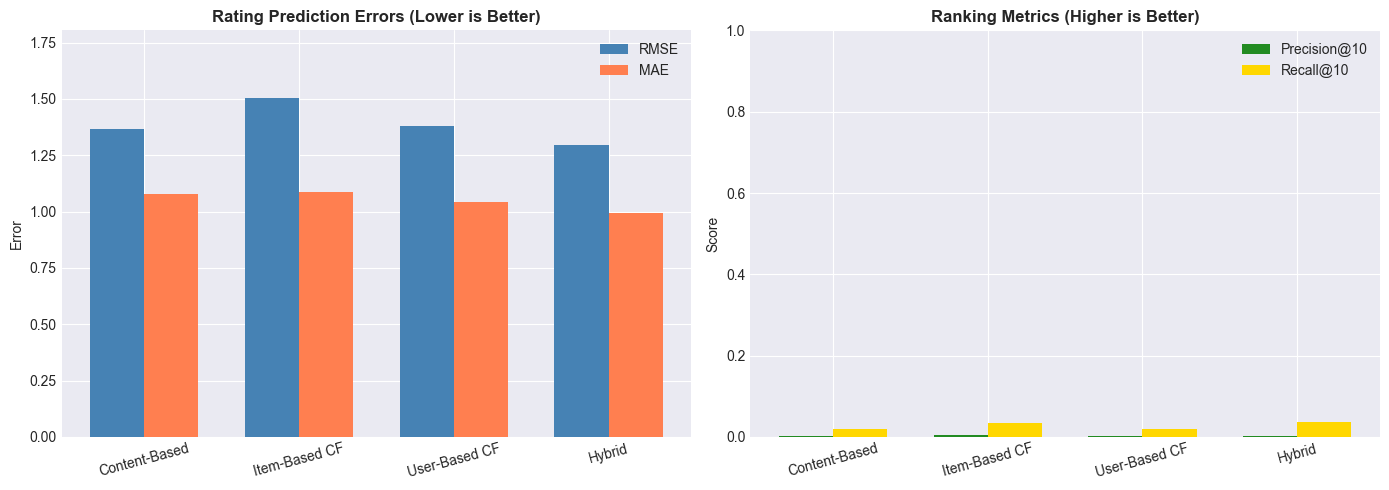

In [135]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Content-Based', 'Item-Based CF', 'User-Based CF', 'Hybrid']
x = np.arange(len(models))
width = 0.35

# Rating metrics
ax1 = axes[0]
rmse_vals = [content_metrics['rmse'], item_metrics['rmse'], user_metrics['rmse'], hybrid_metrics['rmse']]
mae_vals = [content_metrics['mae'], item_metrics['mae'], user_metrics['mae'], hybrid_metrics['mae']]

bars1 = ax1.bar(x - width/2, rmse_vals, width, label='RMSE', color='steelblue')
bars2 = ax1.bar(x + width/2, mae_vals, width, label='MAE', color='coral')
ax1.set_ylabel('Error')
ax1.set_title('Rating Prediction Errors (Lower is Better)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)
ax1.legend()
ax1.set_ylim(0, max(max(rmse_vals), max(mae_vals)) * 1.2)

# Ranking metrics
ax2 = axes[1]
prec_vals = [content_metrics['precision_k'], item_metrics['precision_k'], user_metrics['precision_k'], hybrid_metrics['precision_k']]
rec_vals = [content_metrics['recall_k'], item_metrics['recall_k'], user_metrics['recall_k'], hybrid_metrics['recall_k']]

bars3 = ax2.bar(x - width/2, prec_vals, width, label='Precision@10', color='forestgreen')
bars4 = ax2.bar(x + width/2, rec_vals, width, label='Recall@10', color='gold')
ax2.set_ylabel('Score')
ax2.set_title('Ranking Metrics (Higher is Better)', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15)
ax2.legend()
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


## 8. Save Metrics to MongoDB

In [136]:
# MongoDB connection settings
MONGODB_URL = "mongodb://localhost:27017"
MONGODB_DATABASE = "anime_recommendation_db"

async def save_metrics_to_mongodb():
    """Save all model metrics to MongoDB."""
    client = AsyncIOMotorClient(MONGODB_URL)
    db = client[MONGODB_DATABASE]
    collection = db['model_metrics']
    
    models_data = [
        {
            "model_name": "Content-Based Filtering",
            "trained_at": datetime.utcnow(),
            "rmse": content_metrics['rmse'],
            "mae": content_metrics['mae'],
            "precision_k": content_metrics['precision_k'],
            "recall_k": content_metrics['recall_k'],
            "ndcg_k": content_metrics['ndcg_k'],
            "description": "Recommends based on anime features (genres) using TF-IDF"
        },
        {
            "model_name": "Item-Based Collaborative Filtering",
            "trained_at": datetime.utcnow(),
            "rmse": item_metrics['rmse'],
            "mae": item_metrics['mae'],
            "precision_k": item_metrics['precision_k'],
            "recall_k": item_metrics['recall_k'],
            "ndcg_k": item_metrics['ndcg_k'],
            "description": "Recommends based on item-item similarity"
        },
        {
            "model_name": "User-Based Collaborative Filtering",
            "trained_at": datetime.utcnow(),
            "rmse": user_metrics['rmse'],
            "mae": user_metrics['mae'],
            "precision_k": user_metrics['precision_k'],
            "recall_k": user_metrics['recall_k'],
            "ndcg_k": user_metrics['ndcg_k'],
            "description": "Recommends based on similar user preferences"
        },
        {
            "model_name": "Hybrid Model",
            "trained_at": datetime.utcnow(),
            "rmse": hybrid_metrics['rmse'],
            "mae": hybrid_metrics['mae'],
            "precision_k": hybrid_metrics['precision_k'],
            "recall_k": hybrid_metrics['recall_k'],
            "ndcg_k": hybrid_metrics['ndcg_k'],
            "description": "Combines Content-Based and Collaborative Filtering"
        }
    ]
    
    for model_data in models_data:
        await collection.update_one(
            {"model_name": model_data["model_name"]},
            {"$set": model_data},
            upsert=True
        )
        print(f"Saved: {model_data['model_name']}")
    
    client.close()
    print("\nAll metrics saved to MongoDB!")

# Run async function
await save_metrics_to_mongodb()


Saved: Content-Based Filtering
Saved: Item-Based Collaborative Filtering
Saved: User-Based Collaborative Filtering
Saved: Hybrid Model

All metrics saved to MongoDB!


## 9. Recommendation Demo

In [137]:
# Demo recommendations for a user
def demo_recommendations(user_id, n=10):
    """Show recommendations from all models for a user."""
    print(f"\nRECOMMENDATIONS FOR USER {user_id}")
    print("=" * 60)
    
    # Get user's rated anime
    user_rated = {r['anime_id']: r['rating'] for r in train_ratings if r['user_id'] == user_id}
    liked = [aid for aid, rating in user_rated.items() if rating >= 7]
    
    print(f"\nUser has rated {len(user_rated)} anime")
    
    # Show top rated anime by this user
    print(f"\nUser's Top Rated Anime:")
    top_rated = sorted(user_rated.items(), key=lambda x: x[1], reverse=True)[:5]
    for aid, rating in top_rated:
        anime = anime_clean[anime_clean['anime_id'] == aid]
        if not anime.empty:
            print(f"  - {anime.iloc[0]['name']} (Rating: {rating})")
    
    # Get recommendations from each model
    print(f"\nRECOMMENDATIONS:")
    print("-" * 60)
    
    # Content-Based
    print("\nContent-Based:")
    content_recs = content_model.predict(user_id, n=n, liked_anime_ids=liked)
    for i, aid in enumerate(content_recs[:5], 1):
        anime = anime_clean[anime_clean['anime_id'] == aid]
        if not anime.empty:
            print(f"   {i}. {anime.iloc[0]['name']} (Avg Rating: {anime.iloc[0]['rating']:.1f})")
    
    # Item-Based
    print("\nItem-Based CF:")
    item_recs = item_model.predict(user_id, n=n)
    for i, aid in enumerate(item_recs[:5], 1):
        anime = anime_clean[anime_clean['anime_id'] == aid]
        if not anime.empty:
            print(f"   {i}. {anime.iloc[0]['name']} (Avg Rating: {anime.iloc[0]['rating']:.1f})")
    
    # User-Based
    print("\nUser-Based CF:")
    user_recs = user_model.predict(user_id, n=n)
    for i, aid in enumerate(user_recs[:5], 1):
        anime = anime_clean[anime_clean['anime_id'] == aid]
        if not anime.empty:
            print(f"   {i}. {anime.iloc[0]['name']} (Avg Rating: {anime.iloc[0]['rating']:.1f})")
    
    # Hybrid
    print("\nHybrid Model:")
    hybrid_recs = hybrid_model.predict(user_id, n=n)
    for i, aid in enumerate(hybrid_recs[:5], 1):
        anime = anime_clean[anime_clean['anime_id'] == aid]
        if not anime.empty:
            print(f"   {i}. {anime.iloc[0]['name']} (Avg Rating: {anime.iloc[0]['rating']:.1f})")

# Get a random user with enough ratings
active_users = [uid for uid, ratings in defaultdict(list, 
               {r['user_id']: [] for r in train_ratings}).items()]
random_user = random.choice(list(set(r['user_id'] for r in train_ratings)))

demo_recommendations(random_user)



RECOMMENDATIONS FOR USER 10103

User has rated 1 anime

User's Top Rated Anime:
  - Psycho-Pass 2 (Rating: 10)

RECOMMENDATIONS:
------------------------------------------------------------

Content-Based:
   1. Ghost in the Shell (2015) (Avg Rating: 7.7)
   2. Ghost in the Shell: Arise - Border:1 Ghost Pain (Avg Rating: 7.6)
   3. Ghost in the Shell: Arise - Alternative Architecture (Avg Rating: 7.3)
   4. Ghost in the Shell: Arise - Border:4 Ghost Stands Alone (Avg Rating: 7.6)
   5. Ghost in the Shell: Arise - Border:3 Ghost Tears (Avg Rating: 7.5)

Item-Based CF:
   1. Wasurenagumo (Avg Rating: 7.2)
   2. Oni Chichi: Rebuild (Avg Rating: 7.8)
   3. Kakyuusei 2: Hitomi no Naka no Shoujo-tachi (Avg Rating: 6.0)
   4. Wooser no Sono Higurashi: Ken to Pants to Wooser to (Avg Rating: 6.2)
   5. Nama Lo Re: Namakemono The Animation (Avg Rating: 6.4)

User-Based CF:
   1. Great Teacher Onizuka (Avg Rating: 8.8)
   2. Soredemo Sekai wa Utsukushii (Avg Rating: 7.8)
   3. Hakuouki Hekketsur

In [138]:
# Similar anime demo
def demo_similar_anime(anime_id, n=5):
    """Show similar anime for a given anime."""
    anime = anime_clean[anime_clean['anime_id'] == anime_id]
    if anime.empty:
        print(f"Anime ID {anime_id} not found")
        return
    
    anime_info = anime.iloc[0]
    print(f"\nSIMILAR ANIME TO: {anime_info['name']}")
    print(f"   Genres: {anime_info['genre']}")
    print(f"   Rating: {anime_info['rating']:.1f}")
    print("-" * 50)
    
    similar = content_model.get_similar_anime(anime_id, n=n)
    for i, aid in enumerate(similar, 1):
        sim_anime = anime_clean[anime_clean['anime_id'] == aid]
        if not sim_anime.empty:
            info = sim_anime.iloc[0]
            print(f"{i}. {info['name']}")
            print(f"   Genres: {info['genre']}")
            print(f"   Rating: {info['rating']:.1f}")
            print()

# Demo with a popular anime
popular_anime = anime_clean.nlargest(1, 'members').iloc[0]['anime_id']
demo_similar_anime(popular_anime)



SIMILAR ANIME TO: Death Note
   Genres: Mystery, Police, Psychological, Supernatural, Thriller
   Rating: 8.7
--------------------------------------------------
1. Death Note
   Genres: Mystery, Police, Psychological, Supernatural, Thriller
   Rating: 8.7

2. Mousou Dairinin
   Genres: Drama, Mystery, Police, Psychological, Supernatural, Thriller
   Rating: 7.7

3. Higurashi no Naku Koro ni Kai
   Genres: Mystery, Psychological, Supernatural, Thriller
   Rating: 8.4

4. Higurashi no Naku Koro ni Rei
   Genres: Comedy, Mystery, Psychological, Supernatural, Thriller
   Rating: 7.6

5. Mirai Nikki (TV)
   Genres: Action, Mystery, Psychological, Shounen, Supernatural, Thriller
   Rating: 8.1

